## Creating a passing network map in Python

The first step, aside importing the required libreries, will be importing the data from a concrete match. Later on we will be cleaning data and creating new variables that provide us information regarding passing pattern within the team. And finally we plot the passing network.

In [1]:
#!pip install statsbombpy
#!pip install mplsoccer
#!pip install soccerplots
#!pip install collection


from statsbombpy import sb
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.colors as colors
import matplotlib.cm as cmx

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
from highlight_text import fig_text
import matplotlib as mpl
from mplsoccer.pitch import Pitch
from soccerplots.radar_chart import Radar

#Set general use colors
text_color = 'w'

Filter data that belong to women's football matches

In [2]:
#Create dataset for later on gather all womens matches data
PRO = pd.DataFrame() 

#Select data from women's football competitions
df = sb.competitions()
df = df.loc[df['competition_gender'] == "female"].reset_index()


credentials were not supplied. open data access only


Select data from a certain match

In [3]:
##Seleccionar equipo del que obtener el mapa de red de pases 

competition="Women's World Cup"
season="2019"
team="Spain Women's"
id_partido="69161"



#Loop over every women's match and extract information
#wo_comp = women's football competition
#ma_sea = women's football match from certain competition
#wo_ma = women's football match

for z in range(len(df)):
    wom_comp = df.iloc[[z]]
    ma_sea = sb.matches(competition_id=wom_comp['competition_id'].values[0],season_id=wom_comp['season_id'].values[0])
    if wom_comp['competition_name'].values[0]!=competition or wom_comp['season_name'].values[0]!=season:
        continue
    ma_sea = ma_sea[(ma_sea['away_team']==team) | (ma_sea['home_team']==team)]
    #for t in range(len(ma_sea)):
    #    wo_ma = ma_sea.iloc[[t]]
    #    match = sb.events(match_id=wo_ma['match_id'].values[0])
    match = sb.events(match_id=id_partido)

credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only


Select columns that contain the required information and then divide the data from the whole match and split it for every substitution in order to prevent that a substitution might affect the analysis of passing because the formation changes or whatever decision the manager does.

In [4]:
df = match[match['team']==team]

df.type.unique()

#Seleccionar variables de interés
columns=['team','type','location','pass_end_location',"pass_outcome","player",'minute','second']
df = df[columns]

#Obtener variale de minuto en segundos
df['tot_seconds'] = df['minute']*60 + df['second']


#Dividir dataframe con cada sustitucion para evitar que un cambio de jugador ay esquema afecte al analisis
#Split full dataframe whenever a substituion takes place in order to control for possible effects on the team formation
for r in range(len(df[df['type']=='Substitution']['tot_seconds'])):
    
    if r==0:
        globals()['df' + str(r)] = df[df['tot_seconds'] < df[df['type']=='Substitution']['tot_seconds'].values[r]]
    elif r>0:
        globals()['df' + str(r)] = df[df.tot_seconds.between(df[df['type']=='Substitution']['tot_seconds'].values[r-1], df[df['type']=='Substitution']['tot_seconds'].values[r])]
        



Get location of passer and recipient

In [5]:
%%capture

#Get location of passes recipient and passer

for idx, PRO in enumerate([df0,df1,df2]):

    #Get recipient of passes
    PRO['recipient'] = ""
    PRO['recipient'] = PRO['player'].shift(-1)
    
    passes = PRO[PRO['type']=='Pass']
    
    #Get succesfull and failed passes
    filter_list = ['Incomplete', "Out","Pass Offside"]
    successful = passes[~passes['pass_outcome'].isin(filter_list)]
    
    
    
    #Split location variable into coordinates X and Y
 
    #Create coordinates variable
    successful["X"] = ""
    successful["Y"] = ""
    successful["End_X"] = ""
    successful["End_Y"] = ""
    
    
    for value in range(len(successful['location'])):
        successful['X'].iloc[value] = successful['location'].iloc[value][0]
        successful['Y'].iloc[value] = successful['location'].iloc[value][1]
        successful['End_X'].iloc[value] = successful['pass_end_location'].iloc[value][0]
        successful['End_Y'].iloc[value] = successful['pass_end_location'].iloc[value][1]
    del successful['location']
    del successful['pass_end_location']
    
    
    
    
    
    successful['X']=pd.to_numeric(successful['X'])
    successful['Y']=pd.to_numeric(successful['Y'])
    successful['End_X']=pd.to_numeric(successful['End_X'])
    successful['End_Y']=pd.to_numeric(successful['End_Y'])
    
    globals()['df' + str(idx)] = successful


Get average location of each player, count of passes and who got associated with and how frequently

In [6]:
#Seleccionar qué datos (tramos del partido) del que queremos hacer el grafico

#df0 is the passing network of the starting lineup
#df1 in this case is the passing network between the first and second substitution
PRO = df1


#now we need to find the average locations and counts of the passes
average_locations = PRO.groupby('player').agg({'X':['mean'],'Y':['mean','count']})
average_locations.columns = ['x','y','count']


PRO['passer']=PRO['player']
PRO['N_passes'] = PRO['passer'].groupby(PRO['passer']).transform('count')


#now we need to find the number of passes between each player
pass_between = PRO.groupby(['passer','recipient']).player.count().reset_index()
pass_between.rename({'player':'pass_count'},axis='columns',inplace=True)


#merge the average location dataframe. We need to merge on the passer first then the recipient
pass_between = pass_between.merge(average_locations, left_on='passer',right_index=True)
pass_between = pass_between.merge(average_locations, left_on='recipient',right_index=True,suffixes=['', '_End'])



pass_between = pass_between[pass_between['pass_count']>2]


Plot the passing network. Depending on how may passes go through each player the dot representing each player will be bigger. The colored lines will represent how frequent was the association between two concrete player, the more redish more frequently exchanged passes.

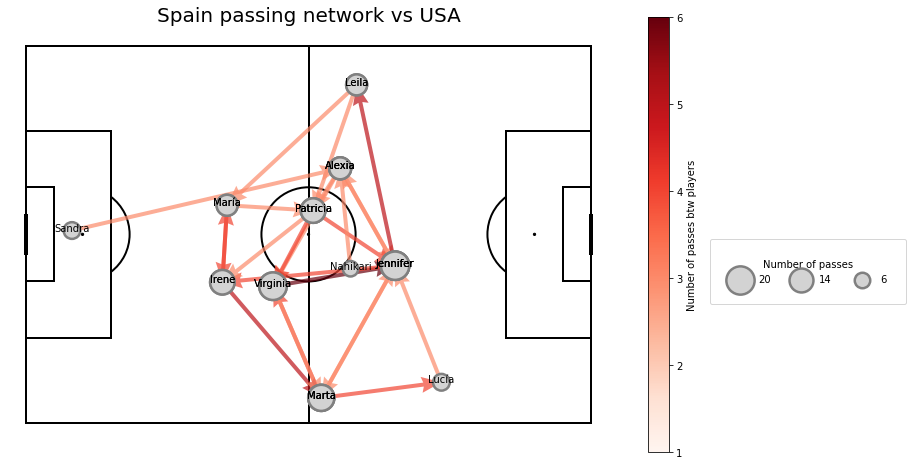

In [8]:
#Plot

fig ,ax = plt.subplots(figsize=(13.5,8))
fig.set_facecolor('#22312b')
ax.patch.set_facecolor('#22312b')


pitch = Pitch(pitch_type='statsbomb', orientation='horizontal',
              pitch_color='white', line_color='black', figsize=(13, 8),
              constrained_layout=False, tight_layout=False)
pitch.draw(ax=ax)



# Elegir intensidad de colores para plotear el numero de pases entre jugadores
# Draw passing line between each player and set how colour represent its frequency
cmap = plt.cm.Reds
cNorm  = colors.Normalize(vmin=1, vmax=np.max(pass_between['pass_count']))
scalarMap = cmx.ScalarMappable(norm=cNorm,cmap=cmap)


for idx in range(0,len(pass_between['pass_count'])):
    colorVal = scalarMap.to_rgba(pass_between.pass_count.iloc[idx])
    pitch.arrows(pass_between.x.iloc[idx],pass_between.y.iloc[idx],pass_between.x_End.iloc[idx],pass_between.y_End.iloc[idx],
                     linewidth = pass_between['pass_count'], headwidth = 4, color = colorVal, ax = ax, zorder = 1, alpha = .7)




#Dibujar posición media de jugadoras
#Plot average location of players and how many passes wenth through them
nodes = pitch.scatter(pass_between.x,pass_between.y,
                     s = pass_between['count']*40, color = '#d3d3d3', edgecolors = 'grey', linewidth = 2.5, alpha = 1, zorder = 1, ax=ax)


#Plot players names
for i in range(len(pass_between.passer)):
    ax.annotate(pass_between.passer.iloc[i].split()[0], (pass_between.x.iloc[i], pass_between.y.iloc[i]), ha='center')


#Plot legend number of passes
nValues = np.arange(0,np.max(pass_between['pass_count']))
scalarMap.set_array(nValues)
clb = plt.colorbar(scalarMap,label="pass_count")
clb.set_label('Number of passes btw players')


#White background
fig.patch.set_facecolor('white')



#Crear leyenda con el tamaño de circulos
#Create legend: circle size
ma = plt.scatter(0, 0, s = max(pass_between['count'])*40, color = '#d3d3d3', edgecolors = 'grey', linewidth = 2.5)
ml = plt.scatter(0, 0, s = min(pass_between['count'])*40, color = '#d3d3d3', edgecolors = 'grey', linewidth = 2.5)
me = plt.scatter(0, 0, s = np.mean(pass_between['count'])*40, color = '#d3d3d3', edgecolors = 'grey', linewidth = 2.5)


plt.legend((ma, me, ml),
           (max(pass_between['count']), round(np.mean(pass_between['count'])), min(pass_between['count'])),
           scatterpoints=1,
           loc='best',
           bbox_to_anchor=(1, 0., 0.5, 0.5),
           title="Number of passes",
           borderpad=2,
           ncol=3,
           fontsize=10)

ma.remove()
me.remove()
ml.remove()

plt.title('Spain passing network vs USA',color='black',size=20)

plt.show()

